# Random Tiles

In [1]:
from pathlib import Path
import os.path as osp

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
!nvidia-smi

Sat Jun  3 17:11:45 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.51                 Driver Version: 375.51                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GRID K520           Off  | 0000:00:03.0     Off |                  N/A |
| N/A   38C    P0    39W / 125W |      0MiB /  4036MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from keras.models import load_model
import openslide

Using TensorFlow backend.


In [4]:
model = load_model('model.h5')

In [5]:
BASE_TRUTH_DIR = Path('/home/ubuntu/data/Ground_Truth_Extracted/Mask')

slide_path = '/home/ubuntu/data/slides/Tumor_009.tif'

In [6]:
import matplotlib.gridspec as gridspec
from skimage.filters import threshold_otsu

def find_patches_from_slide(slide_path, base_truth_dir=BASE_TRUTH_DIR, filter_non_tissue=True):
    """Returns a dataframe of all patches in slide
    input: slide_path: path to WSI file
    output: samples: dataframe with the following columns:
        slide_path: path of slide
        is_tissue: sample contains tissue
        is_tumor: truth status of sample
        tile_loc: coordinates of samples in slide
        
    
    option: base_truth_dir: directory of truth slides
    option: filter_non_tissue: Remove samples no tissue detected
    """
    base_truth_dir = Path(base_truth_dir)
    slide_contains_tumor = osp.basename(slide_path).startswith('Tumor_')
    
    with openslide.open_slide(slide_path) as slide:
        thumbnail = slide.get_thumbnail((slide.dimensions[0] / 256, slide.dimensions[1] / 256))
    
    thumbnail_grey = np.array(thumbnail.convert('L')) # convert to grayscale
    thresh = threshold_otsu(thumbnail_grey)
    binary = thumbnail_grey > thresh
    
    patches = pd.DataFrame(pd.DataFrame(binary).stack())
    patches['is_tissue'] = ~patches[0]
    patches.drop(0, axis=1, inplace=True)
    patches['slide_path'] = slide_path
    
    if slide_contains_tumor:
        truth_slide_path = base_truth_dir / osp.basename(slide_path).replace('.tif', '_Mask.tif')
        with openslide.open_slide(str(truth_slide_path)) as truth:
            thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / 256, truth.dimensions[1] / 256)) 
        
        patches_y = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
        patches_y['is_tumor'] = patches_y[0] > 0
        patches_y.drop(0, axis=1, inplace=True)

        samples = pd.concat([patches, patches_y], axis=1)
    else:
        samples = patches
        samples['is_tumor'] = False
    
    if filter_non_tissue:
        samples = samples[samples.is_tissue == True] # remove patches with no tissue
    samples['tile_loc'] = list(samples.index)
    samples.reset_index(inplace=True, drop=True)
    return samples

def plot_blend(patch, prediction, ax, alpha=0.75):
    """alpha blend patch and prediction.
    https://matplotlib.org/examples/pylab_examples/layer_images.html
    
    input: patch: 256x256x3, rgb image
    input: prediction: 256x256x1, per-pixel tumor probability
    input: ax: maplotlib Axes object
    input: alpha: alpha blend
    """
    
    dx, dy = 0.05, 0.05
    x = np.arange(0, patch.shape[1] - 1, dx)
    y = np.arange(0, patch.shape[0] - 1, dy)
    xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
    extent = xmin, xmax, ymin, ymax

    # fig = plt.figure(frameon=False, figsize=(10, 5))
    Z1 = cv2.cvtColor(patch, code=cv2.COLOR_RGB2GRAY)
    Z2 = prediction

    im1 = ax.imshow(Z1, cmap='gray', extent=extent)
    im2 = ax.imshow(Z2, cmap='jet', alpha=alpha, vmin=0.0, vmax=1.0,
                     extent=extent)
    ax.axis('off');

def plot_patch_with_pred(patch, truth, prediction, title_str='', alpha=0.6):
    """
    input: patch: 256x256x3, rgb image
    input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
    input: prediction: 256x256x1, per-pixel tumor probability
    """
    gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 19, 1])
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[:, 2])
    axc = plt.subplot(gs[:, 3])

    ax0.imshow(patch);
    ax0.set_title('Original')
    
    ax1.imshow(truth.argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    ax1.set_title('Truth mask (white=tumor, black=not_tumor)')
    
    p = ax2.imshow(prediction, cmap='jet', vmin=0, vmax=1);
    ax2.set_title('Prediction heatmap')

    ax3.imshow((prediction > 0.5).astype(np.int), cmap='gray', vmin=0, vmax=1);
    ax3.set_title('Prediction mask (white=tumor, black=not_tumor)')
    
    plot_blend(patch, prediction, ax4, alpha)
    ax4.set_title('Original+Prediction blend')
    
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.suptitle(title_str)
    fig.colorbar(p, cax=axc, orientation="vertical")
    axc.set_title('Probability pixel is tumor')

In [7]:
import cv2
from keras.utils.np_utils import to_categorical
from openslide.deepzoom import DeepZoomGenerator 


NUM_CLASSES = 2 # not_tumor, tumor

def gen_imgs(samples, batch_size, base_truth_dir=BASE_TRUTH_DIR, shuffle=True):
    """This function returns a generator that 
    yields tuples of (
        X: tensor, float - [batch_size, 256, 256, 3]
        y: tensor, int32 - [batch_size, 256, 256, NUM_CLASSES]
    )
    
    
    input: samples: samples dataframe
    input: batch_size: The number of images to return for each pull
    output: yield (X_train, y_train): generator of X, y tensors
    
    option: base_truth_dir: path, directory of truth slides
    option: shuffle: bool, if True shuffle samples
    """
    
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        if shuffle:
            samples = samples.sample(frac=1) # shuffle samples
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
        
            images = []
            masks = []
            for _, batch_sample in batch_samples.iterrows():
                slide_contains_tumor = osp.basename(batch_sample.slide_path).startswith('Tumor_')
                
                with openslide.open_slide(batch_sample.slide_path) as slide:
                    tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
                    img = tiles.get_tile(tiles.level_count-1, batch_sample.tile_loc[::-1])
                    
                # only load truth mask for tumor slides
                if slide_contains_tumor:
                    truth_slide_path = base_truth_dir / osp.basename(slide_path).replace('.tif', '_Mask.tif')
                    with openslide.open_slide(str(truth_slide_path)) as truth:
                        truth_tiles = DeepZoomGenerator(truth, tile_size=256, overlap=0, limit_bounds=False)
                        mask = truth_tiles.get_tile(truth_tiles.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                else:
                    mask = np.zeros((256, 256))

                images.append(np.array(img))
                masks.append(mask)

            X_train = np.array(images)
            y_train = np.array(masks)
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], 256, 256, 2)
            yield X_train, y_train

In [8]:
def predict_from_model(patch, model):
    """Predict which pixels are tumor.
    
    input: patch: 256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    
    prediction = model.predict(patch.reshape(1, 256, 256, 3))
    prediction = prediction[:, :, :, 1].reshape(256, 256)
    return prediction

You can run this cell below over and over to see how the classifier is performing on random patches.

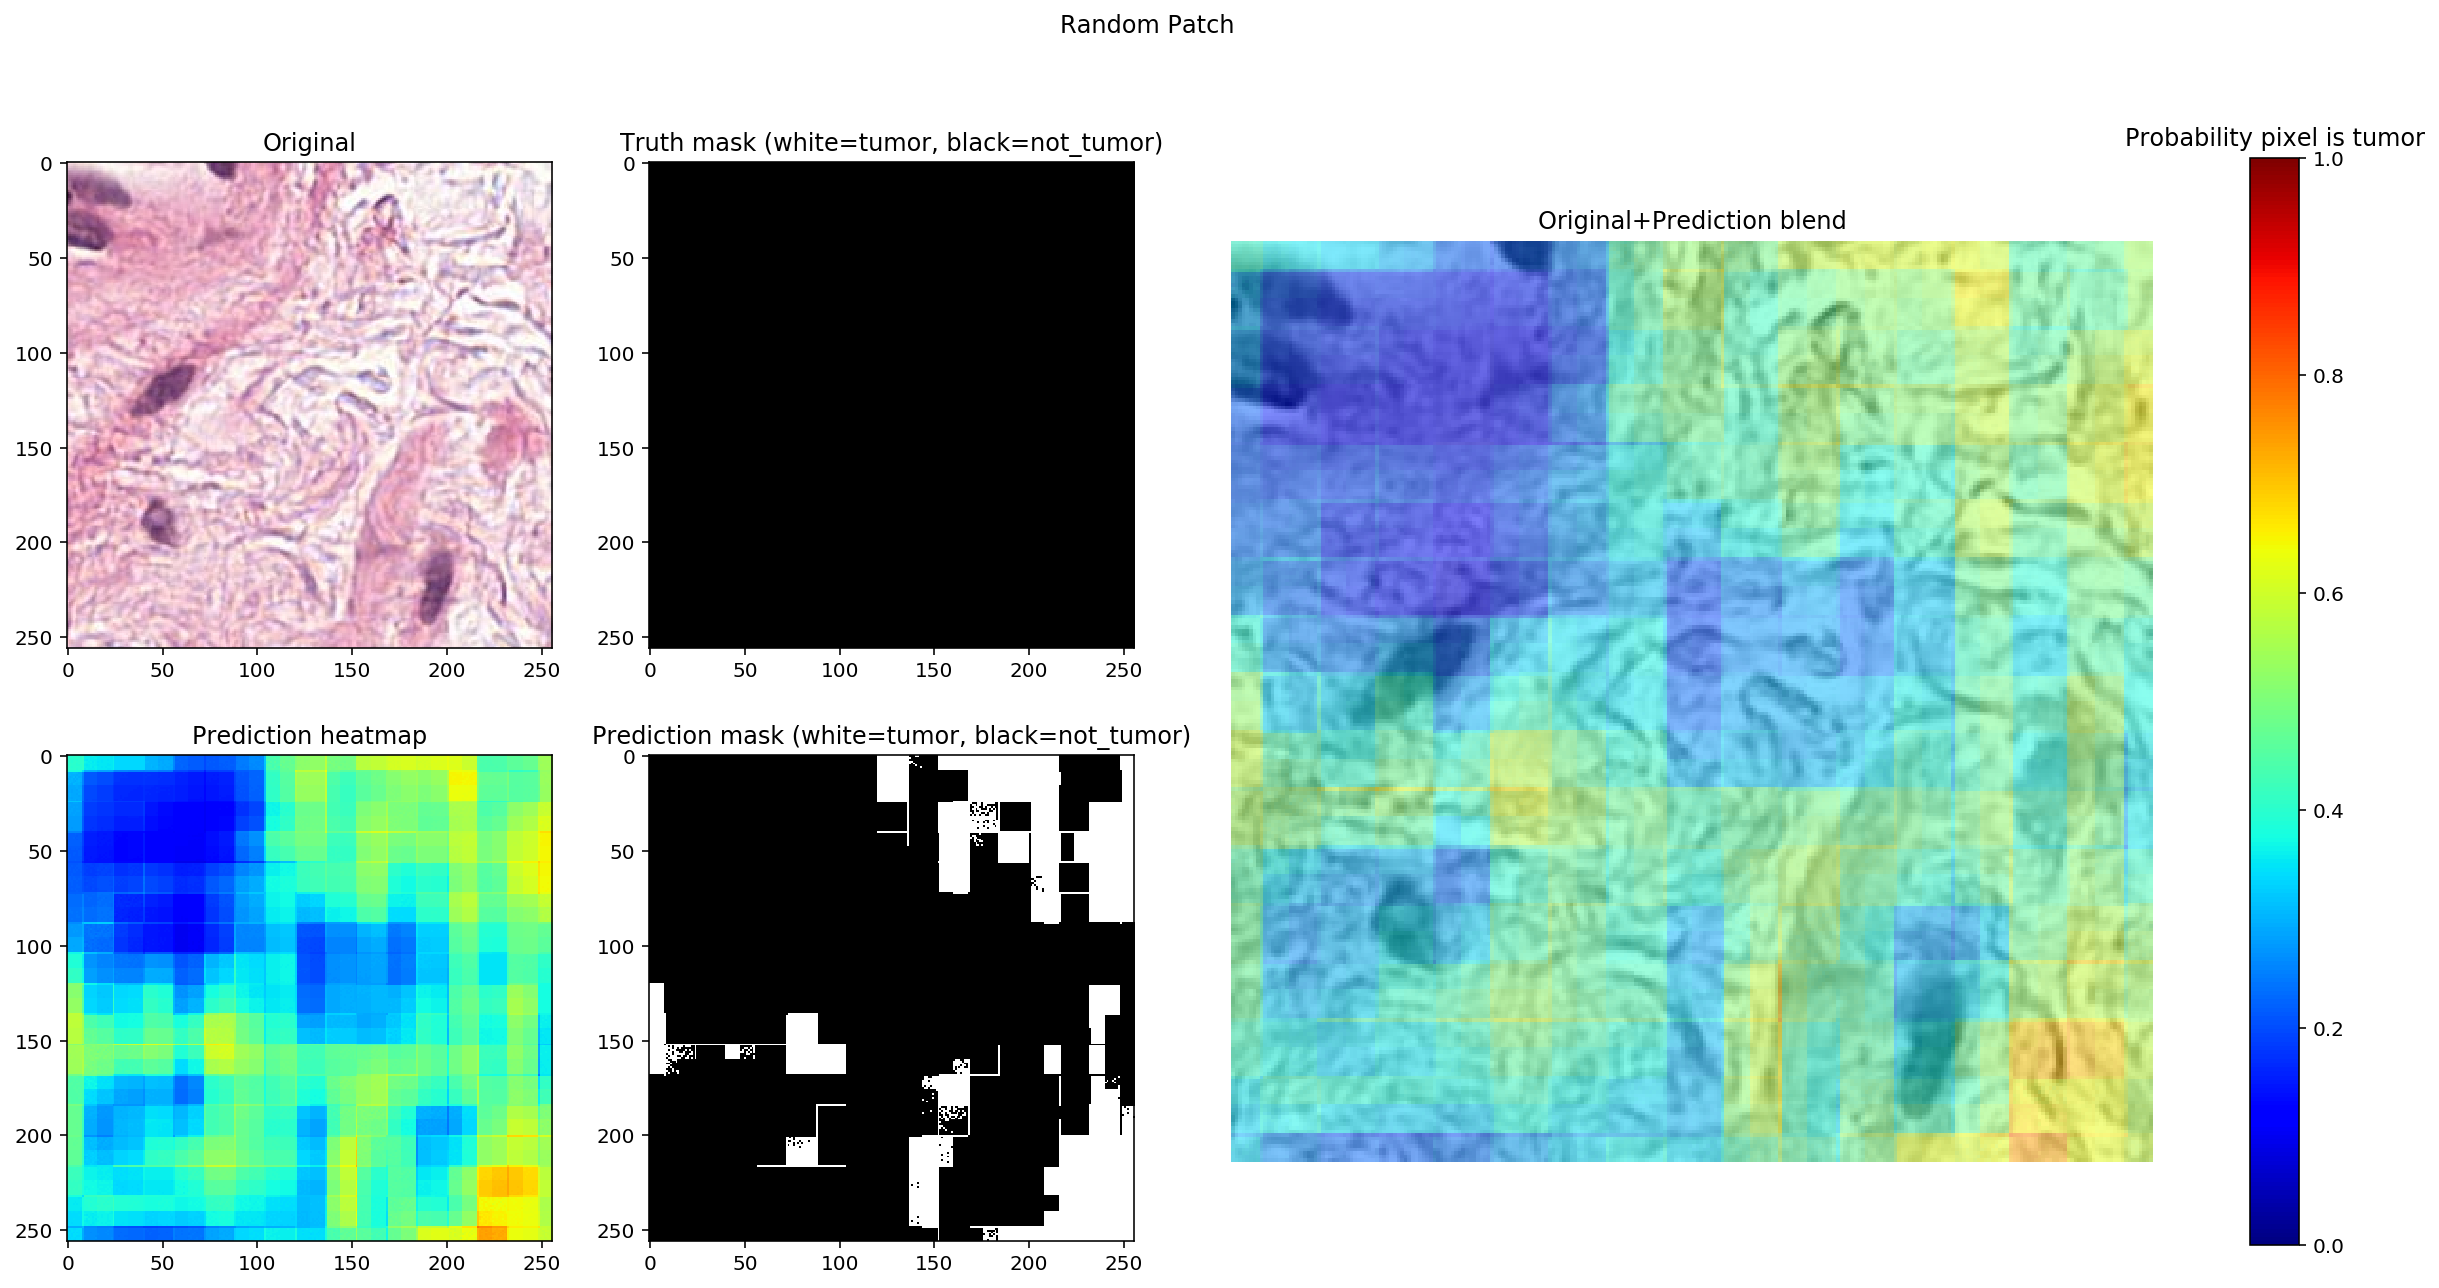

In [9]:
def get_random_patch_from_samples(samples, random_state=None):
    X_i, y_i = next(gen_imgs(samples.sample(1, random_state=random_state), 1))
    return X_i, y_i

all_tissue_samples = find_patches_from_slide(slide_path)
X_i, y_i = get_random_patch_from_samples(all_tissue_samples)
pred_i = predict_from_model(X_i, model)
plot_patch_with_pred(X_i[0], y_i[0], pred_i, title_str='Random Patch', alpha=0.5)

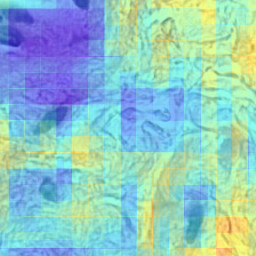

In [10]:
from PIL import Image
from matplotlib import cm

# output = Image.fromarray(X_i[0])
# overlay = Image.fromarray(np.uint8(cm.jet(pred_i)*255))
output = X_i[0]
overlay = np.uint8(cm.jet(pred_i)*255)[:,:,:3]
alpha = 0.5
res = cv2.addWeighted(overlay, alpha, output, 1-alpha, 0, output)
# plt.imshow(res)
Image.fromarray(res)

In [ ]:
plt.imshow(res)

In [ ]:
model.cl